In [1]:
import torch
import numpy as np
import os 
import inspect
import sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentdir = os.path.dirname(parentdir)
sys.path.insert(0, parentdir) 

from utils import set_seed, query_environment_info, read_config_from_yaml
from model import  Quad_Value_Net, Policy,WaveFunction_Koopman_dynamics
from convex_solver import create_convex_solver
from roll_out import roll_out
from dataset import RLDataset
import controlgym as gym
from controlgym.helpers.plotting import _plot_coupled_pde
import matplotlib.pyplot as plt


torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
set_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = read_config_from_yaml("training_scripts/wave/config.yaml")

[INFO] Setting the seed to 2024
[INFO] Loaded data from training_scripts/wave/config.yaml


In [2]:
# Create environment
env_name = config["env_name"]
process_noise_cov = config["process_noise_cov"]
sensor_noise_cov = config["sensor_noise_cov"]
n_state = config["n_state"]
n_obs = config["n_observation"]
n_action = config["n_action"]
observation_limit = config["observation_limit"]
action_limit = config["action_limit"]
R_weight = config["R_weight"]
Q_weight = config["Q_weight"]
env = gym.make(env_name, process_noise_cov=process_noise_cov, 
                         sensor_noise_cov=sensor_noise_cov,
                         n_state=n_state, n_observation=n_obs, n_action=n_action,
                         action_limit=action_limit, 
                         observation_limit=observation_limit,
                         R_weight=R_weight, 
                         Q_weight=Q_weight)
env.n_steps = config["eval_T"]
env_info = query_environment_info(env, env_name)
state_dim = env.observation_space.shape[0] 
act_dim = env.action_space.shape[0]

[INFO] Creating the environment: <WaveEnv instance>
Name: wave
Action Space: Box(-1.0, 1.0, (10,), float64)
Observation Space: Box(-10.0, 10.0, (50,), float64)
Reward Range: (-1000000000000000.0, 1000000000000000.0)



In [3]:
# Construct and Load Model
save_path = "trained_weights"
num_steps = config["num_steps"]
hidden_dim = config["hidden_dim"]

pos_dim = int(state_dim/2)
velocity_dim = int(state_dim/2)

Kdys_model = WaveFunction_Koopman_dynamics(pos_dim=pos_dim, velocity_dim=velocity_dim,hidden_dim=hidden_dim, act_dim=act_dim, num_steps=num_steps).to(device)
Kdys_model.load_state_dict(torch.load(save_path + '/KoopmanDynamics.pt', map_location=torch.device('cpu')))
Kz = torch.load(save_path + '/Kz.pt', map_location=torch.device('cpu'))
Jz_B = torch.load(save_path + '/Jz_B.pt', map_location=torch.device('cpu'))
Kdys_model.koopman.Kz = Kz.to(device)
Kdys_model.koopman.Jz_B = Jz_B.to(device)
Kdys_model.to(device)

WaveFunction_Koopman_dynamics(
  (koopman): KoopmanOp()
  (encoder): WaveFunctionEncoder(
    (position_enocder): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Tanh()
    )
    (velocity_encoder): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Tanh()
    )
    (joint_encoder): Linear(in_features=64, out_features=64, bias=True)
  )
  (decoder): WaveFunctionDecoder(
    (joint_decoder): Linear(in_features=64, out_features=64, bias=True)
    (position_decoder): Sequential(
      (0): Tanh()
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Tanh()
      (3): Linear(in_features=

100%|██████████| 10/10 [00:00<00:00, 39.19it/s]


(8, 50)


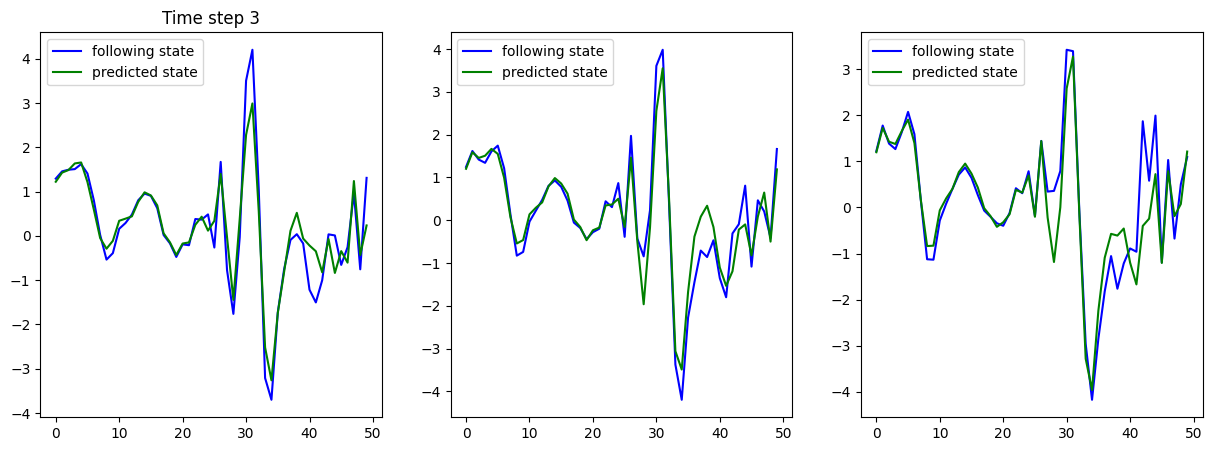

In [4]:
## Evaluate the predicition of the Koopman Dynamics
roll_out_sampler = roll_out(env, env_info)
num_trajactories=10
max_time_step=20
for i in range(1):
    test_buffer = roll_out_sampler.roll_out_sampler_with_env(num_trajactories=num_trajactories,
                                                             max_time_step=max_time_step, random_action=True)
    test_dataset = RLDataset(num_steps, state_dim, act_dim, 
                             state_hidden_dim=hidden_dim, 
                             act_hidden_dim=8, 
                             sample_traj_length=max_time_step, 
                             capacity=num_trajactories*(max_time_step-num_steps-1))
    test_dataset.obtain_data_from_obs_buffer(test_buffer)

j = np.random.randint(0, num_trajactories)
initial_states, actions, following_states, rewards, dones = test_dataset.__getitem__(j)

pred_next_states = []
for i in range(num_steps):
    state = initial_states[i].to(device).unsqueeze(0)
    action = actions[i].to(device).unsqueeze(0)
    
    next_state = Kdys_model(state, action).squeeze(0).detach().cpu().numpy()
    pred_next_states.append(next_state)

pred_next_states = np.array(pred_next_states)
print(pred_next_states.shape)
n_half_state_dim = state_dim 
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].plot(following_states[1, :n_half_state_dim], c="b", label='following state')
axes[0].plot(pred_next_states[1, :n_half_state_dim], c="g", label='predicted state')
axes[0].set_title("Time step 1")
axes[0].legend()
axes[1].plot(following_states[2, :n_half_state_dim], c="b", label='following state')
axes[1].plot(pred_next_states[2, :n_half_state_dim], c="g", label='predicted state')
axes[0].set_title("Time step 2")
axes[1].legend()
axes[2].plot(following_states[3, :n_half_state_dim], c="b", label='following state')
axes[2].plot(pred_next_states[3, :n_half_state_dim], c="g", label='predicted state')
axes[0].set_title("Time step 3")
axes[2].legend()
plt.show()

In [5]:
value_net = Quad_Value_Net(hidden_dim).to(device)
value_net.load_state_dict(torch.load(save_path + '/Quad_Value_Net.pt', map_location=torch.device('cpu')))


cvx_solver = create_convex_solver(env_info)()
policy = Policy(cvx_solver)

[INFO] Cretateing the Convex Solver for wave


In [6]:
# Start Evaluation
eval_T = config["eval_T"]
eval_episodes = config["eval_episodes"]
eval_rewards = [[] for i in range(eval_episodes)]
eval_traj = np.zeros((eval_episodes, eval_T+1, state_dim))
eval_traj_obs = np.zeros((eval_episodes, eval_T+1, state_dim))
eval_actions = np.zeros((eval_episodes, eval_T+1, act_dim))


for n in range(eval_episodes):
    
    test_init_state = env.init_state[:25] + np.random.normal(0, 0.01, 25)
    test_init_state = np.concatenate((test_init_state, np.zeros(25))) 

    env_test = gym.make(env_name, process_noise_cov=process_noise_cov, 
                        sensor_noise_cov=sensor_noise_cov,
                        n_state=n_state, n_observation=n_obs, n_action=n_action,
                        action_limit=action_limit, 
                        observation_limit=observation_limit,
                        Q_weight=Q_weight,
                        R_weight=R_weight,
                        init_state=test_init_state)
    env_test.n_steps = config["eval_T"]
    
    t = 0
    state = env_test.reset()[0]
    eval_traj_obs[n, t, :] = state
    eval_traj[n, t, :] = env_test.state
    while t < eval_T:
        t += 1

        state = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
        action = policy.select_actions(Kdys_model, value_net, state, if_batch=False).detach().cpu().numpy()

        eval_traj_obs[n, t, :] = state.detach().cpu().numpy()
        eval_actions[n, t, :] = action
        next_state, reward, done, _, _ = env_test.step(action)
        eval_rewards[n].append(reward)
        state = next_state
        
        eval_traj[n, t, :] = env_test.state
        
        if done:
            break
    print("Test Episode:", n, " Reward:", np.sum(eval_rewards[n]))

Test Episode: 0  Reward: -220.65131542063477
Test Episode: 1  Reward: -211.43705340814873
Test Episode: 2  Reward: -254.41944703200144
Test Episode: 3  Reward: -212.46940964683196
Test Episode: 4  Reward: -226.5078806581713
Test Episode: 5  Reward: -239.83177004749993
Test Episode: 6  Reward: -355.4300762393376
Test Episode: 7  Reward: -246.82774120150177
Test Episode: 8  Reward: -218.83440130313548
Test Episode: 9  Reward: -218.19615568716762
Test Episode: 10  Reward: -208.64478939305644
Test Episode: 11  Reward: -224.4897893714393
Test Episode: 12  Reward: -234.50348915978498
Test Episode: 13  Reward: -224.68703651726386
Test Episode: 14  Reward: -340.6697884534746
Test Episode: 15  Reward: -212.8095018094017
Test Episode: 16  Reward: -215.92752030984082
Test Episode: 17  Reward: -220.09234851542018
Test Episode: 18  Reward: -213.41549854088652
Test Episode: 19  Reward: -211.98278218866974
Test Episode: 20  Reward: -211.94142506396682
Test Episode: 21  Reward: -244.61739412096108
Tes

In [7]:
env_test.state_traj = eval_traj[0].T

eval_rewards = np.array(eval_rewards)
print("Mean Reward: ", np.mean(np.sum(eval_rewards, axis=1)))
print("Std Reward: ", np.std(np.sum(eval_rewards, axis=1)))

save_eval_path = "eval_results"
if not os.path.exists(save_eval_path):
    os.makedirs(save_eval_path)
save_eval_path = save_eval_path + "/" + "{}".format(env_name)
if not os.path.exists(save_eval_path):
    os.makedirs(save_eval_path)
    
np.save(save_eval_path + "/" + "eval_traj.npy", eval_traj)
np.save(save_eval_path + "/" + "eval_actions.npy", eval_actions)
np.save(save_eval_path + "/" + "eval_rewards.npy", eval_rewards)

Mean Reward:  -231.2222792361821
Std Reward:  25.632569384741856


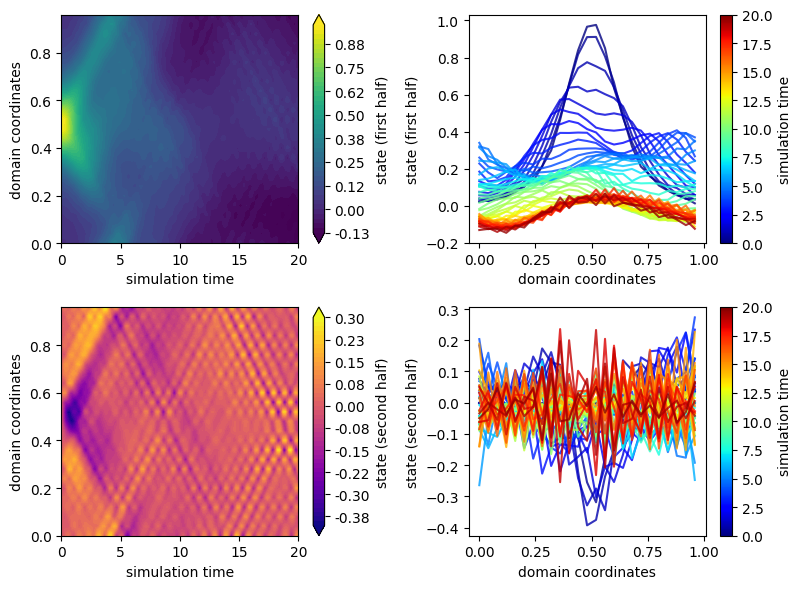

In [8]:
_plot_coupled_pde(env_test, save_eval_path, display=True, surface3d=False)